In [9]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import regexp_replace, col, lower
from pyspark.ml.feature import Tokenizer, StopWordsRemover, CountVectorizer, IDF
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

In [2]:
spark = SparkSession.builder \
    .appName("Sentiment Analysis ") \
    .getOrCreate()

In [3]:
spark

In [4]:
df = spark.read.csv("train.csv", header=True, inferSchema=True)

In [5]:
df.printSchema()

root
 |-- class_index: integer (nullable = true)
 |-- review_title: string (nullable = true)
 |-- review_text: string (nullable = true)



In [6]:
df.show()

+-----------+--------------------+--------------------+
|class_index|        review_title|         review_text|
+-----------+--------------------+--------------------+
|          2|Stuning even for ...|This sound track ...|
|          2|The best soundtra...|I'm reading a lot...|
|          2|            Amazing!|"This soundtrack ...|
|          2|Excellent Soundtrack|I truly like this...|
|          2|Remember, Pull Yo...|If you've played ...|
|          2|an absolute maste...|I am quite sure a...|
|          1|        Buyer beware|"This is a self-p...|
|          2|      Glorious story|I loved Whisper o...|
|          2|    A FIVE STAR BOOK|I just finished r...|
|          2|Whispers of the W...|This was a easy t...|
|          1|          The Worst!|A complete waste ...|
|          2|          Great book|This was a great ...|
|          2|          Great Read|I thought this bo...|
|          1|           Oh please|I guess you have ...|
|          1|Awful beyond belief!|"I feel I have

# Data preprocessing

In [7]:
# Rename columns for clarity
df = df.withColumnRenamed("class_index", "label").withColumnRenamed("review_text", "text")

# Preprocessing: Text cleaning (remove punctuation, convert to lowercase)
df = df.withColumn("clean_text", regexp_replace(col("text"), "[^a-zA-Z0-9\\s]", ""))
df = df.withColumn("clean_text", lower(col("clean_text")))

# Tokenization
tokenizer = Tokenizer(inputCol="clean_text", outputCol="tokens")
df = tokenizer.transform(df)

# Remove Stopwords
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
df = stopwords_remover.transform(df)

# Select relevant columns after preprocessing
preprocessed_data = df.select("label", "review_title", "clean_text", "filtered_tokens")

# machine learning using  spark MLlib

In [8]:
# Split data into training and testing sets
train_data, test_data = preprocessed_data.randomSplit([0.8, 0.2], seed=42)

# Feature extraction: CountVectorizer and TF-IDF
count_vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="raw_features")
idf = IDF(inputCol="raw_features", outputCol="features")

# Classifier: Logistic Regression
lr = LogisticRegression(featuresCol="features", labelCol="label")

# Build the Pipeline
pipeline = Pipeline(stages=[count_vectorizer, idf, lr])

# Train the model
model = pipeline.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

# Display results
predictions.select("clean_text", "label", "prediction").show(truncate=False)
print(f"Model Accuracy: {accuracy:.2f}")



+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+----------+
|clean_text                                                                                                                                                  

<ipython-input-10-c84c67798d03>:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  class_accuracy = prediction_df.groupby("label").apply(lambda x: (x["label"] == x["prediction"]).mean())


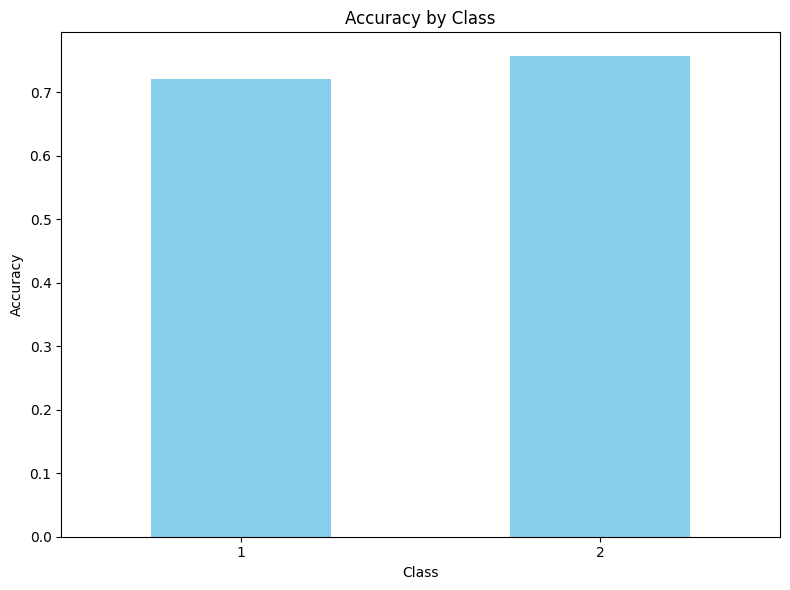

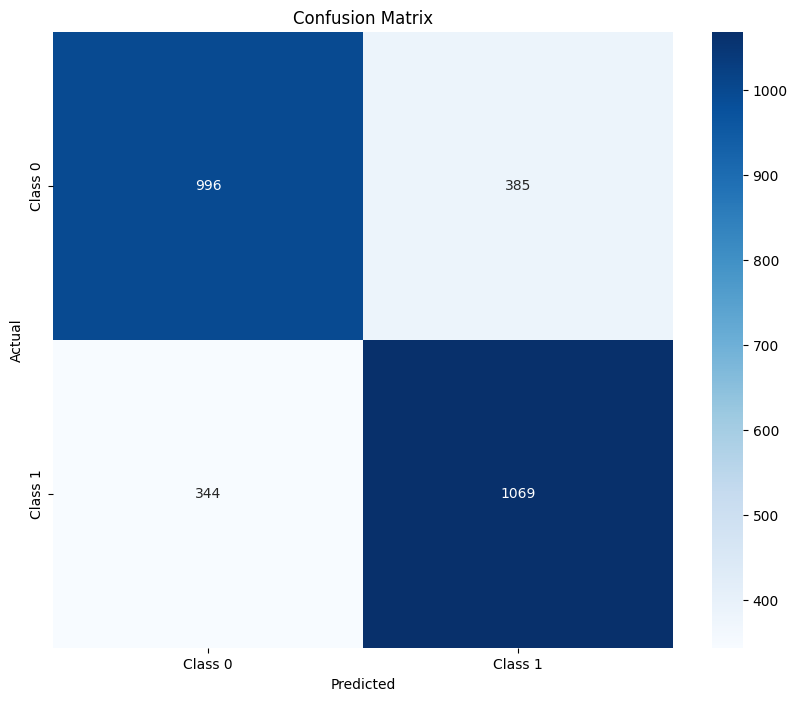

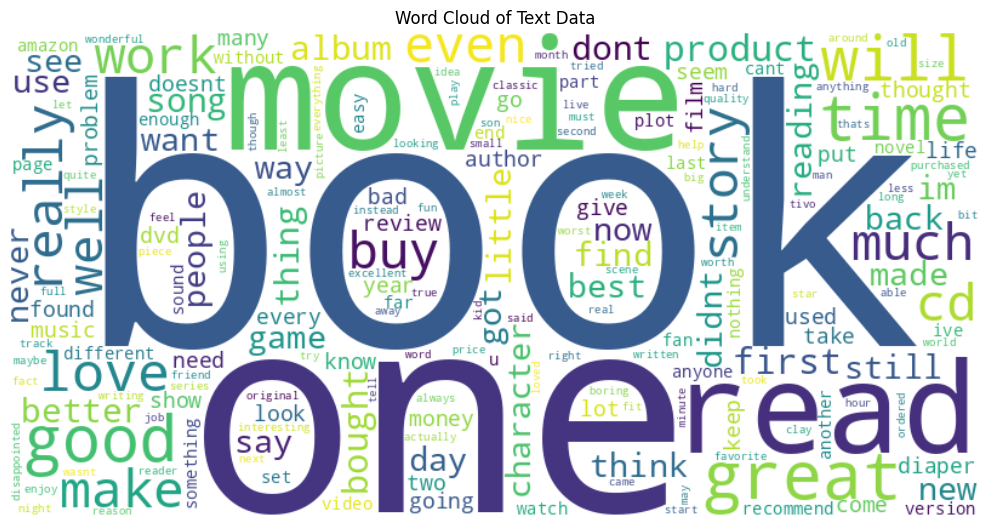

In [10]:
# Visualization: Accuracy by Class
prediction_df = predictions.select("label", "prediction").toPandas()
class_accuracy = prediction_df.groupby("label").apply(lambda x: (x["label"] == x["prediction"]).mean())

plt.figure(figsize=(8, 6))
class_accuracy.plot(kind="bar", color="skyblue")
plt.title("Accuracy by Class")
plt.xlabel("Class")
plt.ylabel("Accuracy")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Visualization: Confusion Matrix
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(prediction_df["label"], prediction_df["prediction"])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Visualization: Word Cloud for Text Data
text_data = " ".join(predictions.select("clean_text").toPandas()["clean_text"])
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text_data)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Text Data")
plt.tight_layout()
plt.show()